In [16]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 
import xfields as xf
from scipy.optimize import curve_fit

In [17]:
line = xt.Line.from_json('sps.json')
particle_ref=line.particle_ref

line_matching = line.copy()
line_matching.build_tracker()

line.build_tracker()
twiss=line.twiss()

clight=constants.speed_of_light
circumference = line.get_length()

Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [18]:
from ion_properties import lead,calcium,xenon


In [19]:
sig_delta_list = np.linspace(2e-5, 2.2e-4, 50)
n_emitt_list=np.linspace(1e-7,1.7e-6,51)

bunch_length_list=np.linspace(0.0063,0.071,50) # this corresponds to the momentum spreads above

In [20]:
dp_list=[]
for ion in [lead]:

    # Ion properties:
    q0 = ion.q0
    mass0 = ion.mass0

    gamma = ion.gamma_cooling
    beta= ion.beta_rel
    p0c = mass0*gamma*beta #eV/c

    bunch_intensity = ion.bunch_intensity

    particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0, gamma=gamma)

    line.particle_ref=particle_ref

    nemitt = 1.5e-6 # m*rad (normalized emittance)
    sigma_z = 0.063 # m
    sigma_z=ion.bunch_length
    # sigma_z=9.5*1e-2

    emittance=nemitt/(beta*gamma)

    num_particles=int(1e5)

    particles = xp.generate_matched_gaussian_bunch(
            num_particles=num_particles,
            total_intensity_particles=bunch_intensity,
            nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
            particle_ref=particle_ref,
            line=line,        
            )
    particles._init_random_number_generator()

    particles0=particles.copy()
    # sigma_dp=2e-4  
    sigma_dp=np.std(particles.delta)

    print(sigma_dp*1e5)

    dp_list.append(sigma_dp)

*** Maximum RMS bunch length 0.23410655471239558m.
... distance to target bunch length: -6.3000e-02
... distance to target bunch length: 1.6464e-01
... distance to target bunch length: 7.8245e-02
... distance to target bunch length: -3.7042e-03
... distance to target bunch length: -7.4446e-05
... distance to target bunch length: -1.7696e-08
... distance to target bunch length: 3.0957e-07
--> Bunch length: 0.0629999823037981
--> Emittance: 0.12257870084693502
19.778914610470306


In [21]:
bunch_intensity

90000000.0

In [22]:
##################
# Laser Cooler #
##################

#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)


# Ion excitation energy:
ion_excited_lifetime=ion.excited_lifetime
hw0 = ion.hw0 # eV
hc=constants.hbar*clight/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

# Shift laser wavelength for fast longitudinal cooling:
#lambda_l = lambda_l*(1+1*sigma_dp) # m

lambda_l = ion.lambda_l

laser_frequency = clight/lambda_l # Hz
sigma_w = 2*np.pi*laser_frequency*sigma_dp
#sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
#print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
#print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 1.3e-3 #m
laser_energy = 5e-3

laser_x = ion.laser_x

GF_IP = xt.PulsedLaser(
                laser_x=laser_x,
                laser_y=0,
                laser_z=0,
                
                laser_direction_nx = 0,
                laser_direction_ny = ny,
                laser_direction_nz = nz,
                laser_energy         = laser_energy, # J
                laser_duration_sigma = sigma_t, # sec
                laser_wavelength = lambda_l, # m
                laser_waist_radius = laser_waist_radius, # m
                laser_waist_shift = 0, # m
                ion_excitation_energy = hw0, # eV
                ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                )

In [23]:
# Define the range of values for emittance and bunch length
emittance_list = np.linspace(1e-7, 1e-5, 10)  # Normalized emittance values (in m*rad)
bunch_length_list = np.linspace(0.0063, 0.071, 10)  # This corresponds to the momentum spreads above

# Create a 2D array to store the emittance growth rates
dp_p_values = np.zeros(len(bunch_length_list))
transverse_growth_rates = np.zeros((len(bunch_length_list), len(emittance_list)))
longitudinal_growth_rates = np.zeros((len(bunch_length_list), len(emittance_list)))

# Define the exponential function
def exponential_func(x, a, b):
    return a * np.exp(x * b)

for i, sigma_z_loop in enumerate(tqdm(bunch_length_list, desc="Bunch Length Loop")):
    for j, nemitt_loop in tqdm(enumerate(emittance_list), desc="Emittance Loop", leave=False):
        print(f'BUNCH LENGTH = {sigma_z_loop*1e4}')

        line = xt.Line.from_json('sps.json')
        particle_ref = line.particle_ref

        line_matching = line.copy()
        line_matching.build_tracker()

        line.build_tracker()
        twiss = line.twiss()

        clight = constants.speed_of_light
        circumference = line.get_length()

        # Ion properties:
        q0 = ion.q0
        mass0 = ion.mass0

        gamma = ion.gamma_cooling
        beta = ion.beta_rel
        p0c = mass0 * gamma * beta  # eV/c

        bunch_intensity = ion.bunch_intensity

        particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0, gamma=gamma)
        line.particle_ref = particle_ref

        num_particles = int(1e3)

        particles = xp.generate_matched_gaussian_bunch(
            num_particles=num_particles,
            total_intensity_particles=bunch_intensity,
            nemitt_x=nemitt_loop, nemitt_y=nemitt_loop, sigma_z=sigma_z_loop,
            particle_ref=particle_ref,
            line=line_matching,
        )
        particles._init_random_number_generator()
        sigma_dp = np.std(particles.delta)
        dp_p_values[i] = sigma_dp

        # Simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
        max_time_s = 1
        int_time_s = 0.01
        T_per_turn = circumference / (clight * beta)
        num_turns = int(max_time_s / T_per_turn)
        save_interval = int(int_time_s / T_per_turn)

        # Create a monitor object, to reduce held data
        monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                                      n_repetitions=int(num_turns / save_interval),
                                      repetition_period=save_interval,
                                      num_particles=num_particles)

        ibs_kick = xf.IBSKineticKick(num_slices=50)
        line.configure_intrabeam_scattering(
            element=ibs_kick, name="ibskick", index=-1, update_every=50
        )

        line.discard_tracker()
        IP_index = 16675
        line.insert_element('monitor', element=monitor, index=IP_index)
        line.insert_element('GF_IP', element=GF_IP, index=IP_index)  # This way monitor comes after the laser

        # At interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
        beta_x = twiss.betx[IP_index]
        beta_y = twiss.bety[IP_index]
        alpha_x = twiss.alfx[IP_index]
        alpha_y = twiss.alfy[IP_index]

        gamma_x = twiss.gamx[IP_index]
        gamma_y = twiss.gamy[IP_index]

        Dx = twiss.dx[IP_index]
        Dpx = twiss.dpx[IP_index]

        Dy = twiss.dy[IP_index]
        Dpy = twiss.dpy[IP_index]

        context = xo.ContextCpu(omp_num_threads=6)
        line.build_tracker(_context=context)

        line.track(particles, num_turns=num_turns,
                   turn_by_turn_monitor=False, with_progress=False)

        # Extract relevant values
        x = monitor.x[:, :, 0]
        px = monitor.px[:, :, 0]
        y = monitor.y[:, :, 0]
        py = monitor.py[:, :, 0]
        delta = monitor.delta[:, :, 0]
        zeta = monitor.zeta[:, :, 0]
        state = monitor.state[:, :, 0]
        time = monitor.at_turn[:, 0, 0] * T_per_turn

        action_x = (gamma_x * (x - Dx * delta) ** 2 + 2 * alpha_x * (x - Dx * delta) * (px - Dpx * delta) + beta_x * (px - Dpx * delta) ** 2)
        action_y = (gamma_y * (y - Dy * delta) ** 2 + 2 * alpha_y * (y - Dy * delta) * (py - Dpy * delta) + beta_y * (py - Dpy * delta) ** 2)

        emittance_x = np.mean(action_x, axis=1) * gamma / 2
        emittance_y = np.mean(action_y, axis=1) * gamma / 2

        # Fit the transverse emittance data to the exponential function
        params_transverse, _ = curve_fit(exponential_func, time, emittance_x)
        _, b = params_transverse
        transverse_growth_rates[i, j] = b

        # Calculate longitudinal emittance
        mean_z = np.mean(zeta, axis=1)
        mean_delta = np.mean(delta, axis=1)
        sigma_z = np.std(zeta, axis=1)
        sigma_delta = np.std(delta, axis=1)
        cov_z_delta = np.mean(zeta * delta, axis=1) - mean_z * mean_delta

        longitudinal_emittance = np.sqrt(sigma_z**2 * sigma_delta**2 - cov_z_delta**2)

        # Fit the longitudinal emittance data to the exponential function
        params_longitudinal, _ = curve_fit(exponential_func, time, longitudinal_emittance)
        _, b_longitudinal = params_longitudinal
        longitudinal_growth_rates[i, j] = b_longitudinal

# Save results to NPZ file
np.savez('emittance_growth_rates.npz',
         transverse_growth_rates=transverse_growth_rates,
         longitudinal_growth_rates=longitudinal_growth_rates,
         dp_p_values=dp_p_values,
         emittance_list=emittance_list,
         bunch_length_list=bunch_length_list)




Bunch Length Loop:   0%|          | 0/10 [00:00<?, ?it/s]

BUNCH LENGTH = 63.0


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 63.0


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 63.0


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 63.0


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 63.0


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 63.0


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 63.0


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 63.0


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 63.0


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 63.0


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Bunch Length Loop:  10%|█         | 1/10 [5:08:11<46:13:46, 18491.85s/it]

BUNCH LENGTH = 134.88888888888886


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 134.88888888888886


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 134.88888888888886


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 134.88888888888886


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 134.88888888888886


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 134.88888888888886


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 134.88888888888886


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 134.88888888888886


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 134.88888888888886


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 134.88888888888886


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Bunch Length Loop:  20%|██        | 2/10 [10:42:20<43:07:42, 19407.85s/it]

BUNCH LENGTH = 206.77777777777774


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 206.77777777777774


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 206.77777777777774


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 206.77777777777774


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 206.77777777777774


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 206.77777777777774


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 206.77777777777774


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 206.77777777777774


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 206.77777777777774


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 206.77777777777774


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Bunch Length Loop:  30%|███       | 3/10 [16:24:03<38:42:33, 19907.70s/it]

BUNCH LENGTH = 278.66666666666663


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 278.66666666666663


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 278.66666666666663


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 278.66666666666663


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 278.66666666666663


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 278.66666666666663


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 278.66666666666663


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


BUNCH LENGTH = 278.66666666666663


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Bunch Length Loop:  30%|███       | 3/10 [20:43:39<48:21:51, 24873.08s/it]


KeyboardInterrupt: 

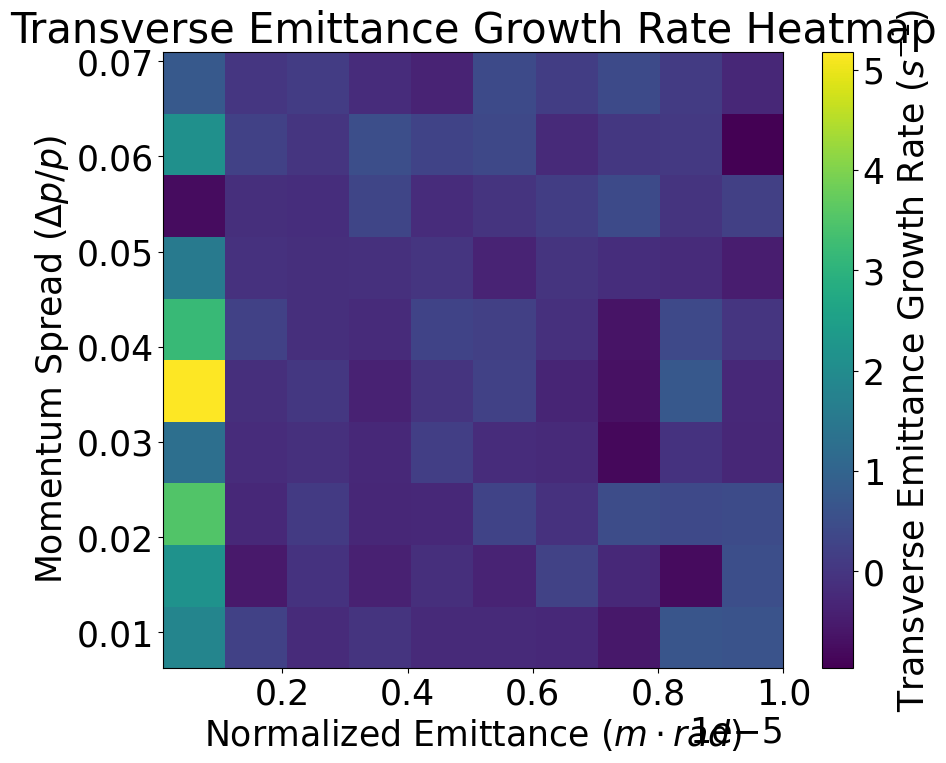

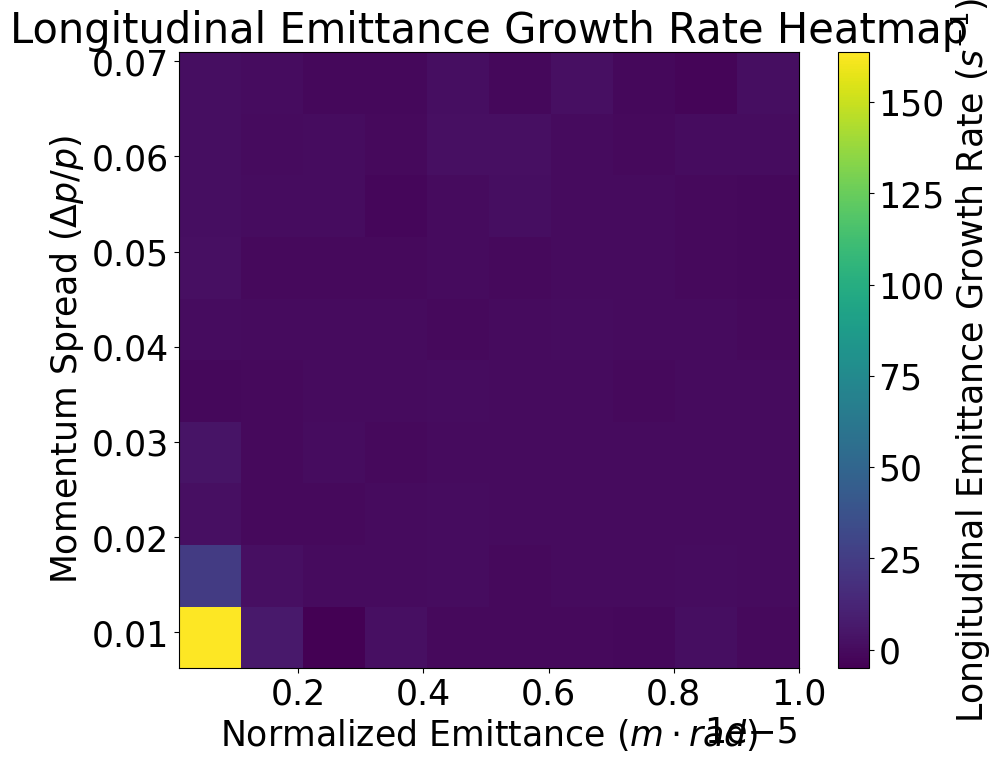

In [ ]:
# Plot the heatmap for transverse growth rate
plt.figure(figsize=(10, 8))
plt.imshow(transverse_growth_rates, extent=[emittance_list.min(), emittance_list.max(), bunch_length_list.min(), bunch_length_list.max()],
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label=r'Transverse Emittance Growth Rate ($s^{-1}$)')
plt.xlabel(r'Normalized Emittance ($m \cdot rad$)')
plt.ylabel(r'Momentum Spread ($\Delta p/p$)')
plt.title(r'Transverse Emittance Growth Rate Heatmap')
plt.show()

# Plot the heatmap for longitudinal growth rate
plt.figure(figsize=(10, 8))
plt.imshow(longitudinal_growth_rates, extent=[emittance_list.min(), emittance_list.max(), bunch_length_list.min(), bunch_length_list.max()],
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label=r'Longitudinal Emittance Growth Rate ($s^{-1}$)')
plt.xlabel(r'Normalized Emittance ($m \cdot rad$)')
plt.ylabel(r'Momentum Spread ($\Delta p/p$)')
plt.title(r'Longitudinal Emittance Growth Rate Heatmap')
plt.show()

In [ ]:
print("beta_x:", beta_x)
print("beta_y:", beta_y)
print("alpha_x:", alpha_x)
print("alpha_y:", alpha_y)
print("gamma_x:", gamma_x)
print("gamma_y:", gamma_y)
print("Dx:", Dx)
print("Dpx:", Dpx)
print("Dy:", Dy)
print("Dpy:", Dpy)


beta_x: 54.46611023891781
beta_y: 44.39557646380093
alpha_x: -1.5456070795347345
alpha_y: 1.3225757163115908
gamma_x: 0.06222043232417969
gamma_y: 0.06192523544814771
Dx: 2.3261652157336967
Dpx: 0.09359130580265473
Dy: -0.0
Dpy: -0.0


Transverse emittance

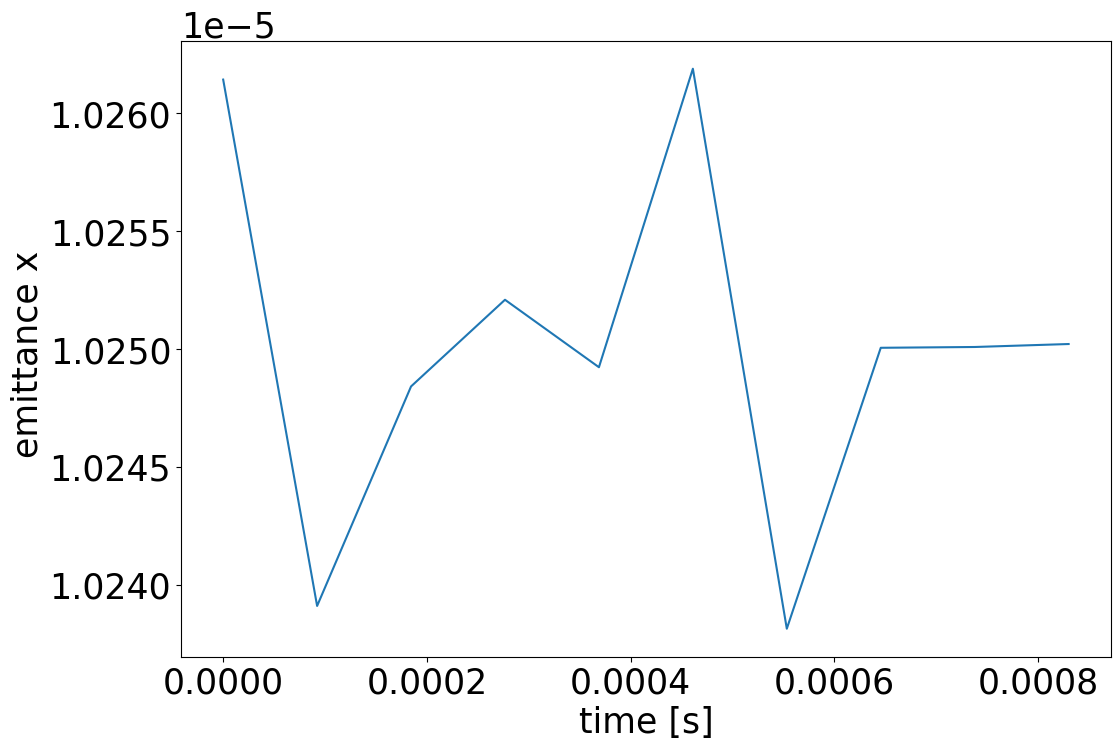

In [ ]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.plot(time,emittance_x)
plt.xlabel('time [s]')
plt.ylabel('emittance x ')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

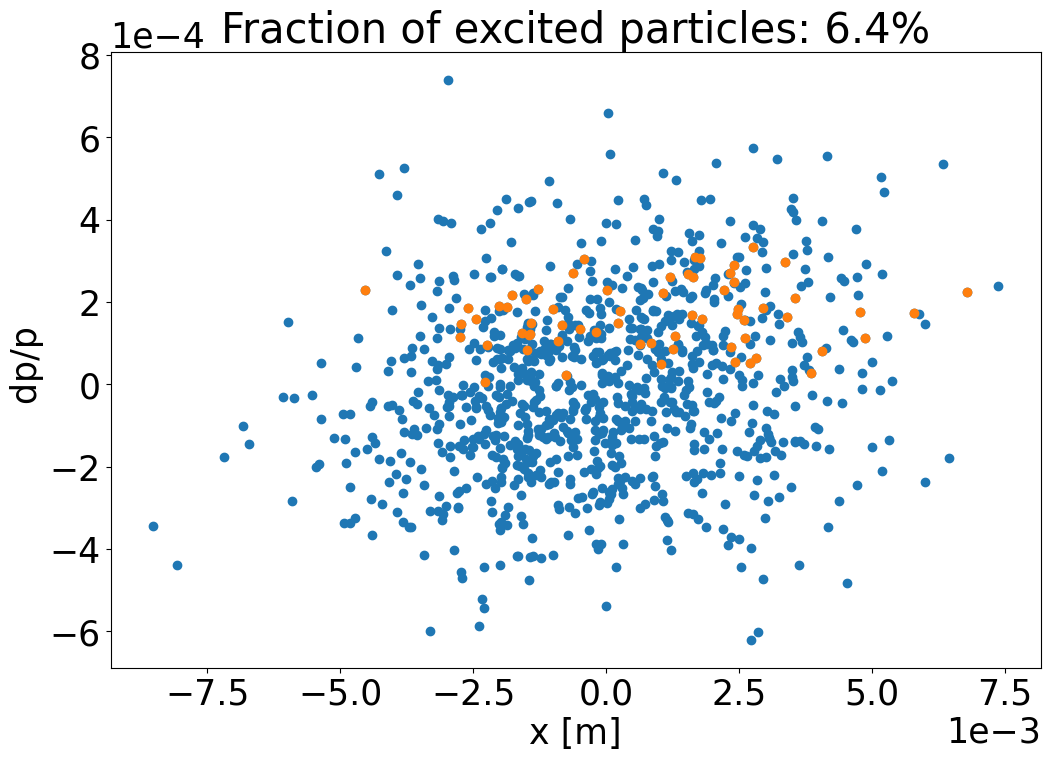

In [ ]:
excited=particles.state==2
fraction_excitation = sum(excited)/len(excited)


plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(x[-1,:],delta[-1,:])
plt.scatter(x[-1,:][excited],delta[-1,:][excited])
plt.xlabel('x [m]')
plt.ylabel('dp/p ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()


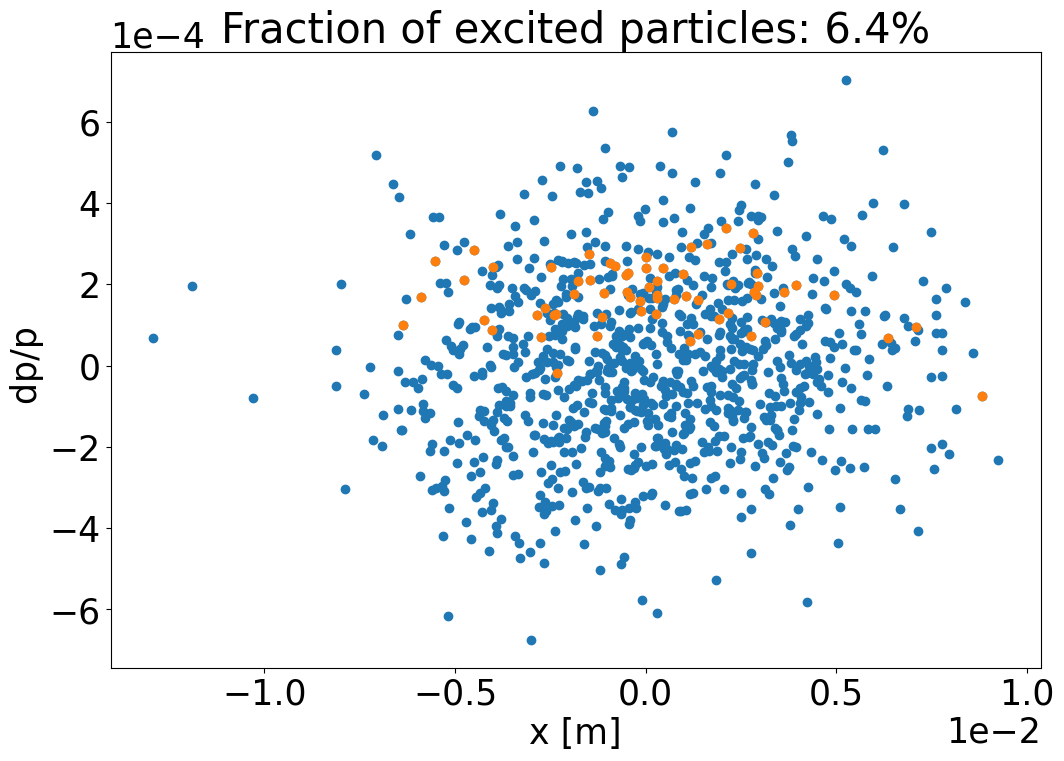

In [ ]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.delta)
plt.scatter(particles.x[excited],particles.delta[excited])
plt.xlabel('x [m]')
plt.ylabel('dp/p ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

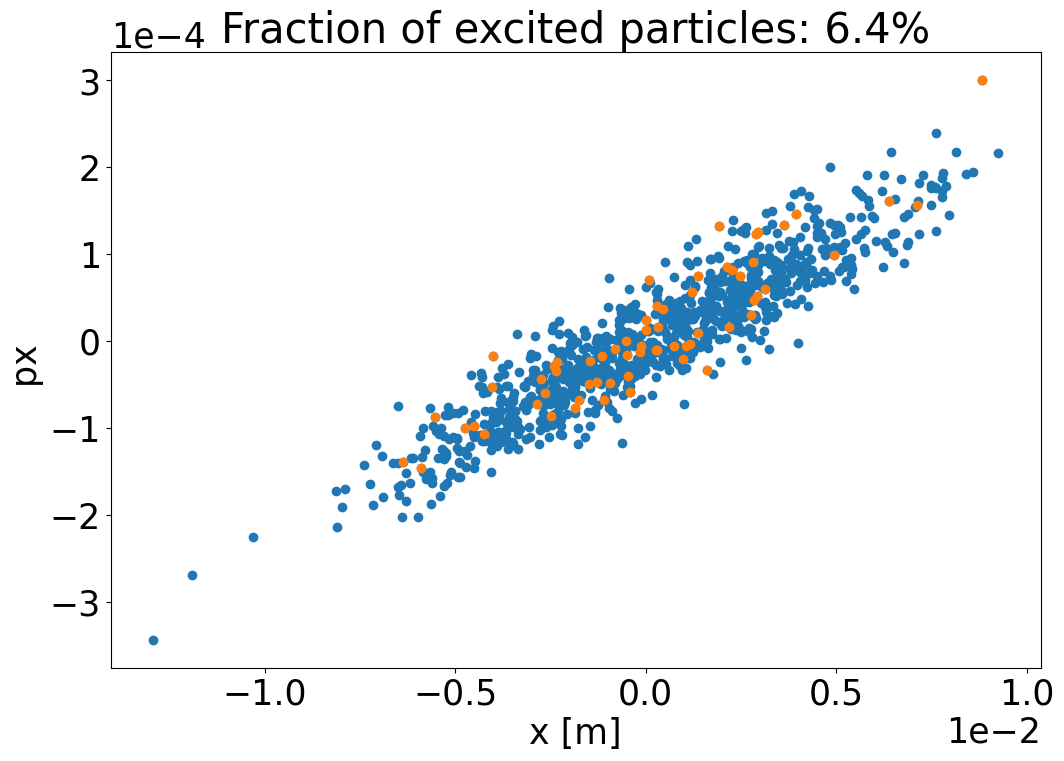

In [ ]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.px)
plt.scatter(particles.x[excited],particles.px[excited])
plt.xlabel('x [m]')
plt.ylabel('px ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()